In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
import bionetwork
import plotting
import pandas
import time
import copy
import argparse
import activationFunctions
from scipy import stats
from sklearn.preprocessing import StandardScaler
# import logging

# logging.basicConfig(level=logging.INFO, format='%(message)s')
# logger = logging.getLogger()
# print2log = logger.info
#
# parser = argparse.ArgumentParser(prog='KDs simulation')
# parser.add_argument('--leaveIn', action='store', default=None)
# args = parser.parse_args()
# curentId = int(args.leaveIn)
curentId = 0

In [2]:
# Probably large enough batches to use batch level regularization
def uniformLoss(data, targetMin = 0, targetMax = 0.99, maxConstraintFactor = 1):
    targetMean = (targetMax-targetMin)/2
    targetVar= (targetMax-targetMin)**2/12

    nodeMean = torch.mean(data, dim=0)
    nodeVar = torch.mean(torch.square(data-nodeMean), dim=0)
    maxVal, _ = torch.max(data, dim=0)
    minVal, _ = torch.min(data, dim=0)

    meanLoss = torch.sum(torch.square(nodeMean - targetMean))
    varLoss =  torch.sum(torch.square(nodeVar - targetVar))
    maxLoss = torch.sum(torch.square(maxVal - targetMax))
    minloss = torch.sum(torch.square(minVal- targetMin))
    maxConstraint = -maxConstraintFactor * torch.sum(maxVal[maxVal.detach()<=0]) #max value should never be negative

    loss = meanLoss + varLoss + minloss + maxLoss + maxConstraint
    return loss

# def uniformLoss(curState, dataIndex, YhatFull, targetMin = 0, targetMax = 0.99, maxConstraintFactor = 10):
#     data = curState.detach().clone()
#     data[dataIndex, :] = YhatFull
#
#     targetMean = (targetMax-targetMin)/2
#     targetVar= (targetMax-targetMin)**2/12
#
#     factor = 1
#     meanFactor = factor
#     varFactor = factor
#     minFactor = factor
#     maxFactor = factor
#     maxConstraintFactor = factor * maxConstraintFactor
#
#     nodeMean = torch.mean(data, dim=0)
#     nodeVar = torch.mean(torch.square(data-nodeMean), dim=0)
#     maxVal, _ = torch.max(data, dim=0)
#     minVal, _ = torch.min(data, dim=0)
#
#     meanLoss = meanFactor * torch.sum(torch.square(nodeMean - targetMean))
#     varLoss =  varFactor * torch.sum(torch.square(nodeVar - targetVar))
#     maxLoss = maxFactor * torch.sum(torch.square(maxVal - targetMax))
#     minloss = minFactor * torch.sum(torch.square(minVal- targetMin))
#     maxConstraint = -maxConstraintFactor * torch.sum(maxVal[maxVal.detach()<=0]) #max value should never be negative
#
#     loss = meanLoss + varLoss + minloss + maxLoss + maxConstraint
#     return loss


In [3]:
class cellLayer(torch.nn.Module):
    def __init__(self, numberOfGenes):
        super(cellLayer, self).__init__()

        weights = torch.ones(numberOfGenes, requires_grad=True, dtype=torch.double)
        weights.data = 1e-3 * weights.data
        bias = torch.zeros(numberOfGenes, requires_grad=True, dtype=torch.double)
        self.weights = torch.nn.Parameter(weights)
        self.bias = torch.nn.Parameter(bias)

    def forward(self, dataCell):
        cellIn = dataCell * self.weights + self.bias

        # leaky cutoff, corresponds to leaky relu but in the oposit direction
        cellInFilter = cellIn.detach() > 0
        cellIn[cellInFilter] = 0.01 * cellIn[cellInFilter]
        return cellIn

    def signRegularization(self, MoAFactor):
        weightFilter = self.weights.detach() < 0
        return MoAFactor * torch.sum(torch.abs(self.weights[weightFilter]))

    def L2Regularization(self, L2):
        L2weight = torch.sum(torch.square(self.weights))
        L2bias = torch.sum(torch.square(self.bias))
        return L2 * (L2weight + L2bias)

class fullModel(torch.nn.Module):
    def __init__(self, nodeNames, inNames, outName, networkList, modeOfAction, inputAmplitude,projectionAmplitude):
        super(fullModel, self).__init__()

        bionetParams = bionetwork.trainingParameters(iterations=100, clipping=1, targetPrecision=1e-6, leak=0.01)
        self.projectAmplitude = projectionAmplitude

        self.cellModel = cellLayer(len(nodeNames))
        self.inputLayer = bionetwork.projectInput(nodeNames, inNames, inputAmplitude, torch.double)
        self.signalingModel = bionetwork.bionet(networkList, len(nodeNames), modeOfAction, bionetParams, 'MML',
                                                torch.double)
        self.projectModel = bionetwork.projectOutput(nodeNames, outName, projectionAmplitude, torch.double)
        #self.bn = torch.nn.BatchNorm1d(len(outName), momentum=0.25,dtype=torch.double)

    def forward(self, dataIn, dataCell, noiseLevel=0):
        Yin = self.inputLayer(dataIn) + self.cellModel(dataCell)
        Yin = Yin + noiseLevel * torch.randn(Yin.shape)
        YhatFull = self.signalingModel(Yin)
        Yhat = self.projectModel(YhatFull)
        #Yhat = self.bn(Yhat)

        return Yhat, YhatFull

    def L2Regularization(self, L2, lbRegularization=0.001):
        cellL2 = self.cellModel.L2Regularization(L2)

        # Signaling model L2
        absFilter = torch.abs(self.signalingModel.weights.detach()) > lbRegularization
        weightLoss = L2 * torch.sum(torch.square(self.signalingModel.weights[absFilter.detach()]))
        biasLoss = L2 * torch.sum(torch.square(self.signalingModel.bias))

        #projectOutputL2 = L2 * torch.sum(torch.square(self.projectionLayer.weights - self.projectAmplitude))
        projectOutputL2 = L2 * torch.sum(torch.square(self.projectModel.weights))

        L2Loss = weightLoss + biasLoss + cellL2 + projectOutputL2
        return L2Loss

    def signRegularization(self, MoAFactor):
        cellSign = self.cellModel.signRegularization(MoAFactor)
        signalingSign = self.signalingModel.signRegularization(MoAFactor)
        signConstraints = cellSign + signalingSign
        return signConstraints


In [4]:
inputAmplitude = 1.0
projectionAmplitude = 0.1

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('../preprocessing/preprocessed_data/macrophageL1000_Ligands-Model.tsv')

# Load input output data
#Load samples
train_samples = pandas.read_csv('../data/10fold_cross_validation/LigandPKN_old//train_sample_' + str(curentId) + '.csv', low_memory=False,index_col=0)
train_samples = train_samples.sample(frac=1).reset_index(drop=True)
#Load TFs
TFsData = pandas.read_csv('../results/trimmed_shrnas_tf_activities_ligandpkn_old.tsv',sep='\t', low_memory=False,index_col=0)
trainTFs = TFsData.loc[train_samples.sig_id.values,:]
outName = list(trainTFs.columns)
#Load KDs
allKds = pandas.read_csv('../preprocessing/preprocessed_data/all_filtered_Kds_ligandpkn_old.tsv',sep='\t', low_memory=False,index_col=0)
allKds = allKds.set_index('sig_id')
inName = list(allKds.columns)
trainKds = allKds.loc[train_samples.sig_id.values,:]
allLigands = pandas.read_csv('../results/Ligands_conditions_old.tsv',sep='\t', low_memory=False,index_col=0)
inName_original = list(allLigands.columns)
#Load cell line data
cellLineMember = pandas.read_csv('../preprocessing/preprocessed_data/all_filtered_cells_ligandpkn_old.tsv', sep='\t', low_memory=False, index_col=0)
cellLineMember = cellLineMember.set_index('sig_id')
TrainCellLineMember = cellLineMember.loc[train_samples.sig_id.values,:]
cellLineLevels = pandas.read_csv('../data/CCLE/trimmed_ccle_ligandpkn_old.tsv', sep='\t', low_memory=False, index_col=0)
cellLineLevels = cellLineLevels.loc[cellLineMember.columns,:]
# scaler = StandardScaler()
# cellLineLevels_scaled = pandas.DataFrame(scaler.fit_transform(cellLineLevels))
# cellLineLevels_scaled.index = cellLineLevels.index
# cellLineLevels_scaled.columns = cellLineLevels.columns
# cellLineLevels_scaled = cellLineLevels_scaled.T
cellLineLevels_scaled = cellLineLevels.T
missingValues = numpy.setdiff1d(nodeNames, cellLineLevels_scaled.index.values)
#Zero padding:
df = pandas.DataFrame(numpy.zeros((len(missingValues), cellLineLevels_scaled.shape[1])), index=missingValues, columns=cellLineLevels_scaled.columns)
cellLineLevels_scaled = cellLineLevels_scaled.append(df)
cellLineLevels_scaled = cellLineLevels_scaled.loc[nodeNames,:]
#cellLineLevels_scaled = cellLineLevels_scaled/cellLineLevels_scaled.max() # scale between zero and one
geneData = cellLineLevels_scaled.values.dot(TrainCellLineMember.values.T).T

In [5]:
#model = torch.load('../preprocessing/preprocessed_data/old_uniform_loss_bs24ep6000_ligands_allcells.pt')

In [12]:
#model.inputLayer.weights.shape

torch.Size([181])

In [6]:
# torch.save(model.state_dict(),'../preprocessing/preprocessed_data/ligands_states_L100.pt')

In [5]:
criterion = torch.nn.MSELoss()

sampleName = trainKds.index.values
X = torch.tensor(trainKds.values, dtype=torch.double)
Xcell = torch.tensor(geneData, dtype=torch.double)
Y = torch.tensor(trainTFs.values.copy(), dtype=torch.double)
N = X.shape[0]

In [6]:
model = fullModel(nodeNames, inName_original, outName, networkList, modeOfAction, inputAmplitude, projectionAmplitude)
model.signalingModel.preScaleWeights()
model.inputLayer.weights.requires_grad = False
#model.projectionLayer.weights.requires_grad = False
#model.signalingModel.bias.data[numpy.isin(nodeNames, outName)] = 0.5 # put all TFs in 0.5 to begin

In [7]:
model_ligand_states = torch.load('../preprocessing/preprocessed_data/ligands_states_L100.pt')
model.load_state_dict(model_ligand_states)
# model.signalingModel.weights = torch.nn.Parameter(model_ligand_states['signalingModel.weights'])
# model.signalingModel.bias = torch.nn.Parameter(model_ligand_states['signalingModel.bias'])
# model.projectionLayer.weights = torch.nn.Parameter(model_ligand_states['projectModel.weights'])
# model.signalingModel.A.data = model.signalingModel.weights
# model.cellModel.weights = torch.nn.Parameter(model_ligand_states['cellModel.bias'])
# model.cellModel.bias.data = torch.nn.Parameter(model_ligand_states['cellModel.weights'])
# model.inputLayer.weights = torch.nn.Parameter(model_ligand_states['inputLayer.weights'])
model.inputLayer.weights.requires_grad = False

In [8]:
#Combine lingand and Kds data
## Load celline ligand data
TFsData_ligands = pandas.read_csv('../results/trimmed_ligands_old_tf_activities.tsv',sep='\t', low_memory=False,index_col=0)
cellLineMember = pandas.read_csv('../preprocessing/preprocessed_data/all_filtered_cells_ligand_old.tsv', sep='\t', low_memory=False, index_col=0)
cellLineMember = cellLineMember.set_index('sig_id')
TrainCellLineMember = cellLineMember.loc[allLigands.index.values,:]
cellLineLevels = pandas.read_csv('../data/CCLE/trimmed_ccle_ligands_old.tsv', sep='\t', low_memory=False, index_col=0)
cellLineLevels = cellLineLevels.loc[cellLineMember.columns,:]
cellLineLevels_scaled = cellLineLevels.T
missingValues = numpy.setdiff1d(nodeNames, cellLineLevels_scaled.index.values)
#Zero padding:
df = pandas.DataFrame(numpy.zeros((len(missingValues), cellLineLevels_scaled.shape[1])), index=missingValues, columns=cellLineLevels_scaled.columns)
cellLineLevels_scaled = cellLineLevels_scaled.append(df)
cellLineLevels_scaled = cellLineLevels_scaled.loc[nodeNames,:]
geneData_ligands = cellLineLevels_scaled.values.dot(TrainCellLineMember.values.T).T

# Combine inNames
allInNames = numpy.unique(numpy.union1d(inName,inName_original))

missingValuesLigands = numpy.setdiff1d(allInNames,inName_original)
df = pandas.DataFrame(numpy.zeros((len(missingValuesLigands), allLigands.shape[0])), index=missingValuesLigands, columns=allLigands.index)
df = df.transpose()
allLigands = pandas.concat((allLigands,df),axis=1)
allLigands = allLigands.loc[:,allInNames]

missingValuesKds = numpy.setdiff1d(allInNames,inName)
df = pandas.DataFrame(numpy.zeros((len(missingValuesKds), trainKds.shape[0])), index=missingValuesKds, columns=trainKds.index)
df = df.transpose()
trainKds = pandas.concat((trainKds,df),axis=1)
trainKds = trainKds.loc[:,allInNames]

In [9]:
# Change input layer node order
dictionary = dict(zip(nodeNames, list(range(len(nodeNames)))))
model.inputLayer.nodeOrder = numpy.array([dictionary[x] for x in allInNames])
weights = 1.0 * torch.ones(len(allInNames), dtype=torch.double)
model.inputLayer.weights.data = weights
model.inputLayer.weights.requires_grad = False

In [10]:
len(nodeNames)

2875

In [11]:
sampleName = allLigands.index.values
X = torch.tensor(allLigands.values, dtype=torch.double)
Xcell = torch.tensor(geneData_ligands, dtype=torch.double)
Y = torch.tensor(TFsData_ligands.values.copy(), dtype=torch.double)
N = X.shape[0]

In [12]:
X.shape

torch.Size([310, 740])

In [13]:
model.eval()
Yhat, YhatFull = model(X,Xcell,0)

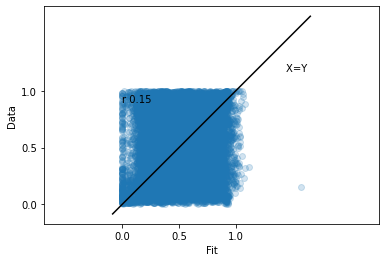

In [14]:
plt.figure()
plt.scatter(Yhat.detach().numpy(), Y.detach().numpy(), alpha=0.2)
plotting.lineOfIdentity()
plotting.addCorrelation(Yhat, Y)
plt.xlabel('Fit')
plt.ylabel('Data')
plt.gca().axis('equal')
plt.gca().set_xticks([0, 0.5, 1])
plt.gca().set_yticks([0, 0.5, 1])